In [1]:
import warnings
import os
import spacy
import json
import random   
import re
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from sklearn.model_selection import train_test_split
from spacy.scorer import Scorer
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [8]:
nlp = spacy.load("en_core_web_sm")

In [3]:

folder_path = "/Users/rishabhralli/Documents/JIIT/Major1/implementation/ResumesJsonAnnotated"

training_data = []

def filter_overlapping_entities(entities):
    entities = sorted(entities, key=lambda x: (x[0], x[1]))  
    filtered_entities = []
    last_end = -1
    for start, end, label in entities:
        if start >= last_end:
            filtered_entities.append((start, end, label))
            last_end = end
    return filtered_entities

def load_data_from_folder(folder_path, num_files=1000):
    data = []
    files = os.listdir(folder_path)
    json_files = [file for file in files if file.endswith(".json")]
    random.shuffle(json_files) 
    selected_files = json_files[:num_files]  
    for filename in selected_files:
        json_file_path = os.path.join(folder_path, filename)
        with open(json_file_path, "r", encoding="utf-8") as file:
            resume_data = json.load(file)
            data.append(resume_data)
    return data

resume_data = load_data_from_folder(folder_path, num_files=4000)

In [4]:
for data in resume_data:
    text = data["text"].strip()  
    annotations = data["annotations"]  


    entities = [(int(start), int(end), "SKILL") for start, end, label in annotations]
    entities = filter_overlapping_entities(entities)  
    training_data.append((text, {"entities": entities})) 


def trim_entity_spans(data):
    """Removes leading and trailing white spaces from entity spans."""
    invalid_span_tokens = re.compile(r'\s')
    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
                valid_start += 1
            while valid_end > 1 and valid_end <= len(text) and invalid_span_tokens.match(text[valid_end - 1]):
                valid_end -= 1
            if valid_start < valid_end:  
                valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data


training_data = trim_entity_spans(training_data)

In [48]:

ner = nlp.get_pipe("ner")


for _, annotations in training_data:
    for start, end, label in annotations.get("entities"):
        ner.add_label(label)


train_data, test_data = train_test_split(training_data, test_size=0.3, random_state=42)

In [6]:

pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]


max_iter = 100
patience = 10
min_delta = 0.001
no_improvement = 0
best_loss = float('inf')


losses_list = []


with nlp.disable_pipes(*unaffected_pipes): 
    optimizer = nlp.resume_training()  
    for iteration in range(max_iter):
        losses = {}
        batches = minibatch(train_data, size=compounding(8.0, 32.0, 1.001))  
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text) 
                example = Example.from_dict(doc, annotations)  
                nlp.update([example], drop=0.3, sgd=optimizer, losses=losses) 
        current_loss = losses.get('ner')
        losses_list.append(current_loss)
        print(f"Iteration {iteration} - Losses: {losses}")

        # Early stopping check
        if current_loss < best_loss - min_delta:
            best_loss = current_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at iteration {iteration}")
            break

Iteration 0 - Losses: {'ner': np.float32(256922.53)}
Iteration 1 - Losses: {'ner': np.float32(227890.52)}
Iteration 2 - Losses: {'ner': np.float32(219790.7)}
Iteration 3 - Losses: {'ner': np.float32(215516.17)}
Iteration 4 - Losses: {'ner': np.float32(213903.03)}
Iteration 5 - Losses: {'ner': np.float32(212078.66)}
Iteration 6 - Losses: {'ner': np.float32(209590.7)}
Iteration 7 - Losses: {'ner': np.float32(208068.1)}
Iteration 8 - Losses: {'ner': np.float32(207049.5)}
Iteration 9 - Losses: {'ner': np.float32(206061.27)}
Iteration 10 - Losses: {'ner': np.float32(204387.83)}
Iteration 11 - Losses: {'ner': np.float32(203220.34)}
Iteration 12 - Losses: {'ner': np.float32(202339.81)}
Iteration 13 - Losses: {'ner': np.float32(200424.83)}
Iteration 14 - Losses: {'ner': np.float32(200206.39)}
Iteration 15 - Losses: {'ner': np.float32(199223.81)}
Iteration 16 - Losses: {'ner': np.float32(198326.61)}
Iteration 17 - Losses: {'ner': np.float32(196769.14)}
Iteration 18 - Losses: {'ner': np.float32(

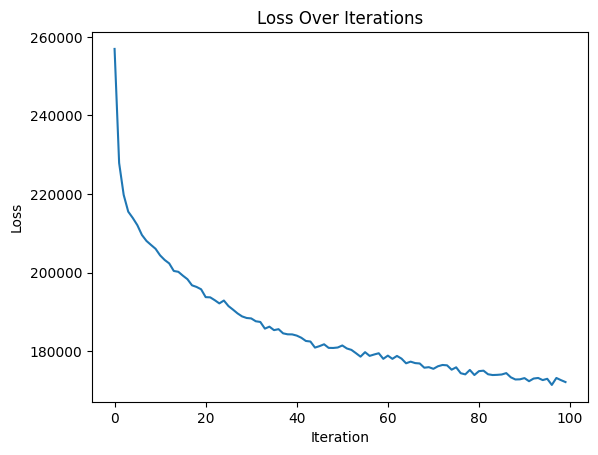

In [7]:
plt.plot(losses_list)
plt.title('Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [10]:
!pip install PyPDF2

  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import PyPDF2


pdf_path = "/Users/rishabhralli/Documents/JIIT/Major1/implementation/Rishabh Ralli- resume.pdf"

with open(pdf_path, "rb") as file:
    reader = PyPDF2.PdfReader(file)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"

print(text)

In [ ]:

doc = nlp(text)


for ent in doc.ents:
    if ent.label_ == "SKILL": 
        print(f"Skill: {ent.text}, Start: {ent.start_char}, End: {ent.end_char}")


print("\nAll Entities:")
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}, Start: {ent.start_char}, End: {ent.end_char}")

In [13]:

def evaluate_model(model, test_data):
    """Evaluates the NER model on the test data.

    Args:
        model (Language): The spaCy model.
        test_data (list): The test data.

    Returns:
        dict: Evaluation metrics.
    """
    examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in test_data]
    scorer = model.evaluate(examples)
    return scorer

In [65]:
len(test_data)

new_test_data=test_data[:1094]+test_data[1095:]

len(new_test_data)

1199

In [66]:

evaluation_results = evaluate_model(nlp, new_test_data)
print("Evaluation Results:", evaluation_results)

Evaluation Results: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'tag_acc': None, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'lemma_acc': None, 'ents_p': 0.764349571246123, 'ents_r': 0.25901104200412994, 'ents_f': 0.38691146862705256, 'ents_per_type': {'SKILL': {'p': 0.764349571246123, 'r': 0.25901104200412994, 'f': 0.38691146862705256}}, 'speed': 23369.975865322274}


In [67]:
print(f"Precision = {evaluation_results['ents_per_type']['SKILL']['p']}")
print(f"Recall = {evaluation_results['ents_per_type']['SKILL']['r']}")
print(f"F1-Score = {evaluation_results['ents_per_type']['SKILL']['f']}")

Precision = 0.764349571246123
Recall = 0.25901104200412994
F1-Score = 0.38691146862705256


In [ ]:
output_dir = "/Users/rishabhralli/Documents/JIIT/Major1/implementation/ltrain_store"  # Output directory where the model will be saved
nlp.to_disk(output_dir)  

print("Model training complete and saved to", output_dir)

Model training complete and saved to /Users/rishabhralli/Documents/JIIT/Major1/implementation/ltrain_store
